# Process to assign EV

In [1]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd

In [6]:
from utils import process_from_census_data, TRS

### Import getting model

In [7]:
model = keras.models.load_model("cnn_20.keras")

### Process to get the total at each SA1
The model selected here is the one that got total SA1 quite close to the actual total - 7819

In [11]:

EXPECTED_SUM = 7819
sa1_data, sa1_tot = process_from_census_data(geo_lev="SA1", 
                                             normalise=True, 
                                             boxcox=False, 
                                             keep_same=True, 
                                             return_tot=True)

In [12]:
predicted = model.predict(sa1_data)
predicted = predicted.flatten()
sa1_data["pred_num_EV_percen"] = predicted
sa1_data["pred_num_EV_percen"]

484/484 [==============================] - 1s 1ms/step


20101100101    0.003368
20101100102    0.003313
20101100105    0.003313
20101100106    0.003377
20101100107    0.003313
                 ...   
21704148034    0.003413
21704148035    0.003313
29797979991    0.014472
29797979992    0.014472
29797979993    0.014472
Name: pred_num_EV_percen, Length: 15481, dtype: float32

In [15]:
predicted_num = sa1_data["pred_num_EV_percen"] * sa1_tot

predicted_num = predicted_num.fillna(0) #na value because that sa1 has no one
predicted_rounded = TRS(predicted_num, know_tot=EXPECTED_SUM)

print(predicted_num.sum(), predicted_rounded.sum(), EXPECTED_SUM)

sa1_data["pred_num_EV"] = predicted_rounded

print(f"""
Check whether this value has negative:
{True in (sa1_data["pred_num_EV"]<0).unique()}
""")

9899.301355244243 7819 7819

Check whether this value has negative
False



## Combine to get total EV for each SA1 in the final

### Process data

In [16]:
file_loc = "output/EV_pred"
geo_lev = "SA1"

In [33]:
df_all = pd.read_csv(f"{file_loc}/{geo_lev}_EV_pred_all.csv")
df_all[geo_lev] = df_all[geo_lev].astype(str)

In [68]:
dict_num_ev =  dict(zip(sa1_data.index.astype(str), sa1_data["pred_num_EV"]))

In [69]:
ls_cols_ev_pred = [x for x in df_all.columns if "EV_pred" in x]

In [70]:
combine_fin_df = df_all[ls_cols_ev_pred+[geo_lev]]

## Assigning EV

In [58]:
combine_fin_df

,EV_pred_forest,EV_pred_baye,EV_pred_lr,EV_pred_GraBoost,EV_pred_Pearsons,SA1
0,0.003988,0.007249,-0.006780,0.001441,0.128262,20302104732
1,0.002178,-0.002708,-0.001990,0.001441,-0.101160,20302104732
2,0.001904,-0.006483,-0.037701,0.001441,-0.239749,20302104732
3,0.003604,0.003209,0.010351,0.001441,-0.179596,20302104732
4,0.004735,0.001560,-0.013556,0.001441,-0.087372,20302104732
...,...,...,...,...,...,...
1902754,0.001483,-0.000362,0.000023,0.001441,-0.076286,21402159223
1902755,0.001297,0.003203,0.001848,0.001441,-0.042461,21402159223
1902756,0.004118,0.000006,-0.023657,0.001441,0.089287,21402159223
1902757,0.002197,0.003857,0.001653,0.001441,0.265632,21402159223


In [55]:
# Make sense to have higher, some sa1 does not have households
print(len(dict_num_ev), len(df_all[geo_lev].unique()))

15481 11964


In [80]:
dict_thres = {}
ls_df = [] # Note these one will have diff index matching with original to combine later

for zone in df_all[geo_lev].unique():
    print(f"DOING {zone}")
    dict_thres[zone] = {}
    sub_df = combine_fin_df[combine_fin_df[geo_lev]==zone]
    num_ev = dict_num_ev[zone]
    ls_series = []
    for ev_pred in ls_cols_ev_pred:
        sort_df = sub_df.sort_values(ev_pred, ascending=False)
        n = len(sort_df)
        arr_val = ["NO" for _ in range(n)]
        arr_val[:num_ev] = ["YES" for _ in range(num_ev)]
        seri_ev_count = pd.Series(arr_val, index=sort_df.index, name=f"check_{ev_pred}")
        ls_series.append(seri_ev_count)

        # Find thres
        thres = sort_df[ev_pred].iat[num_ev-1]
        dict_thres[zone][ev_pred] = thres
    df_zone = pd.concat(ls_series, axis=1) # note the index
    ls_df.append(df_zone)

In [85]:
ev_as_df = pd.concat(ls_df)
ev_as_df = ev_as_df.sort_index()
ev_as_df

,check_EV_pred_forest,check_EV_pred_baye,check_EV_pred_lr,check_EV_pred_GraBoost,check_EV_pred_Pearsons
0,NO,NO,NO,NO,NO
1,NO,NO,NO,NO,NO
2,NO,NO,NO,NO,NO
3,NO,NO,NO,NO,NO
4,NO,NO,NO,NO,NO
...,...,...,...,...,...
1902754,NO,NO,NO,NO,NO
1902755,NO,NO,NO,NO,NO
1902756,NO,NO,NO,NO,NO
1902757,NO,NO,NO,NO,NO


In [86]:
final_df_all = pd.concat([combine_fin_df, ev_as_df], axis=1)
final_df_all

,EV_pred_forest,EV_pred_baye,EV_pred_lr,EV_pred_GraBoost,EV_pred_Pearsons,SA1,check_EV_pred_forest,check_EV_pred_baye,check_EV_pred_lr,check_EV_pred_GraBoost,check_EV_pred_Pearsons
0,0.003988,0.007249,-0.006780,0.001441,0.128262,20302104732,NO,NO,NO,NO,NO
1,0.002178,-0.002708,-0.001990,0.001441,-0.101160,20302104732,NO,NO,NO,NO,NO
2,0.001904,-0.006483,-0.037701,0.001441,-0.239749,20302104732,NO,NO,NO,NO,NO
3,0.003604,0.003209,0.010351,0.001441,-0.179596,20302104732,NO,NO,NO,NO,NO
4,0.004735,0.001560,-0.013556,0.001441,-0.087372,20302104732,NO,NO,NO,NO,NO
...,...,...,...,...,...,...,...,...,...,...,...
1902754,0.001483,-0.000362,0.000023,0.001441,-0.076286,21402159223,NO,NO,NO,NO,NO
1902755,0.001297,0.003203,0.001848,0.001441,-0.042461,21402159223,NO,NO,NO,NO,NO
1902756,0.004118,0.000006,-0.023657,0.001441,0.089287,21402159223,NO,NO,NO,NO,NO
1902757,0.002197,0.003857,0.001653,0.001441,0.265632,21402159223,NO,NO,NO,NO,NO


In [87]:
check_cols = [x for x in final_df_all.columns if "check_" in x]

for c in check_cols:
    print(final_df_all[c].value_counts())

# missing some zones, high chance because the pop synthesis did not synthesize those

check_EV_pred_forest
NO     1896708
YES       6051
Name: count, dtype: int64
check_EV_pred_baye
NO     1896708
YES       6051
Name: count, dtype: int64
check_EV_pred_lr
NO     1896708
YES       6051
Name: count, dtype: int64
check_EV_pred_GraBoost
NO     1896708
YES       6051
Name: count, dtype: int64
check_EV_pred_Pearsons
NO     1896708
YES       6051
Name: count, dtype: int64


In [88]:
final_df_all.to_csv("SA1_FIN_EV_assignment.csv", index=False)

# Mapping to get the final plot

In [105]:
import matplotlib.pyplot as plt
import geopandas as gpd

### Prep data

In [90]:
df_pop = df_all.drop(columns=ls_cols_ev_pred+["hhid", "SA1"])
df_pop = pd.concat([df_pop, ev_as_df], axis=1)
df_pop

,hhsize,dwelltype,hhinc,totalvehs,owndwell,check_EV_pred_forest,check_EV_pred_baye,check_EV_pred_lr,check_EV_pred_GraBoost,check_EV_pred_Pearsons
0,3.0,Separate House,350.0,1.0,Being Purchased,NO,NO,NO,NO,NO
1,2.0,Separate House,3600.0,0.0,Fully Owned,NO,NO,NO,NO,NO
2,2.0,Separate House,1900.0,1.0,Fully Owned,NO,NO,NO,NO,NO
3,3.0,Separate House,350.0,3.0,Fully Owned,NO,NO,NO,NO,NO
4,2.0,Separate House,800.0,2.0,Being Purchased,NO,NO,NO,NO,NO
...,...,...,...,...,...,...,...,...,...,...
1902754,1.0,Other,2850.0,1.0,Fully Owned,NO,NO,NO,NO,NO
1902755,1.0,Separate House,3200.0,2.0,Fully Owned,NO,NO,NO,NO,NO
1902756,1.0,Separate House,2800.0,1.0,Being Purchased,NO,NO,NO,NO,NO
1902757,1.0,Flat or Apartment,3000.0,0.0,Being Rented,NO,NO,NO,NO,NO


In [91]:
dict_counts_methods_atts = {}
ls_check_methods = [f"check_{x}" for x in ls_cols_ev_pred]
# Check each methods
for method in ls_check_methods:
    dict_counts_methods_atts[method] = {}
    df_ev_own = df_pop[df_pop[method]=="YES"]
    df_ev_own.drop(columns=ls_check_methods)
    for att in df_ev_own.columns:
        val_counts = df_ev_own[att].value_counts()
        dict_counts_methods_atts[method][att] = val_counts.sort_index()

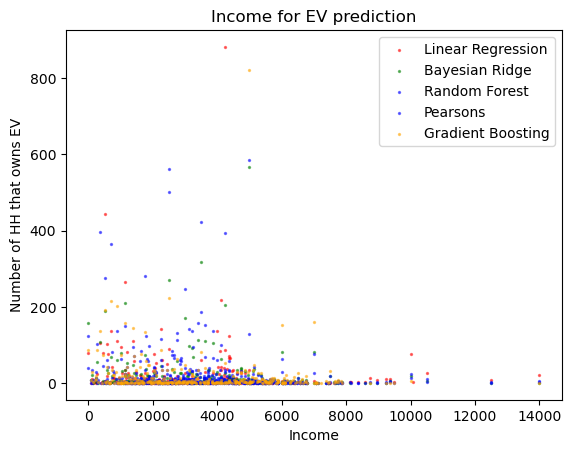

In [92]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

forest = dict_counts_methods_atts["check_EV_pred_forest"]['hhinc']
baye = dict_counts_methods_atts["check_EV_pred_baye"]['hhinc']
lr = dict_counts_methods_atts["check_EV_pred_lr"]['hhinc']
graboost = dict_counts_methods_atts["check_EV_pred_GraBoost"]['hhinc']
pears = dict_counts_methods_atts["check_EV_pred_Pearsons"]['hhinc']

ax1.scatter(lr.index, lr.values, s=2, c='r', label='Linear Regression', alpha=0.5)
ax1.scatter(baye.index, baye.values, s=2, c='g', label='Bayesian Ridge', alpha=0.5)
ax1.scatter(forest.index, forest.values, s=2, c='b', label='Random Forest', alpha=0.5)
ax1.scatter(pears.index, pears.values, s=2, c='b', label='Pearsons', alpha=0.5)
ax1.scatter(graboost.index, graboost.values, s=2, c='orange', label='Gradient Boosting', alpha=0.5)

plt.xlabel("Income")
plt.ylabel("Number of HH that owns EV")
plt.title("Income for EV prediction")
plt.legend(loc='upper right')

In [98]:
def to_plot_mul_bars(dict_check, ls_methods, att):
    print(f"PLOTTING {att}")
    X_lab = df_all[att].unique()
    X_lab.sort()
    hold_val = {}

    for method in ls_methods:
        name_check = f"check_EV_pred_{method}"
        series_counts = dict_check[name_check][att]
        arr_val = []
        for val in X_lab:
            if val not in series_counts.index: 
                arr_val.append(0)
            else:
                arr_val.append(series_counts[val])
        hold_val[method] = arr_val

    x = np.arange(len(X_lab))  # the label locations
    width = 0.1  # the width of the bars
    multiplier = 0

    fig, ax = plt.subplots(layout='constrained', figsize=(20, 10))

    for attribute, counts in hold_val.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, counts, width, label=attribute)
        # ax.bar_label(rects, padding=3)
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Number of HHs that have EV')
    ax.set_title(f'Analyse {geo_lev} - {att}')
    ax.set_xticks(x + width, X_lab)
    ax.legend(loc='best', ncols=3)

    plt.show()


ls_methods = ["forest", "baye", "lr", "GraBoost", "Pearsons"]
    

In [102]:
ls_atts_pop = [x for x in df_ev_own.columns if "EV" not in x]

PLOTTING hhsize


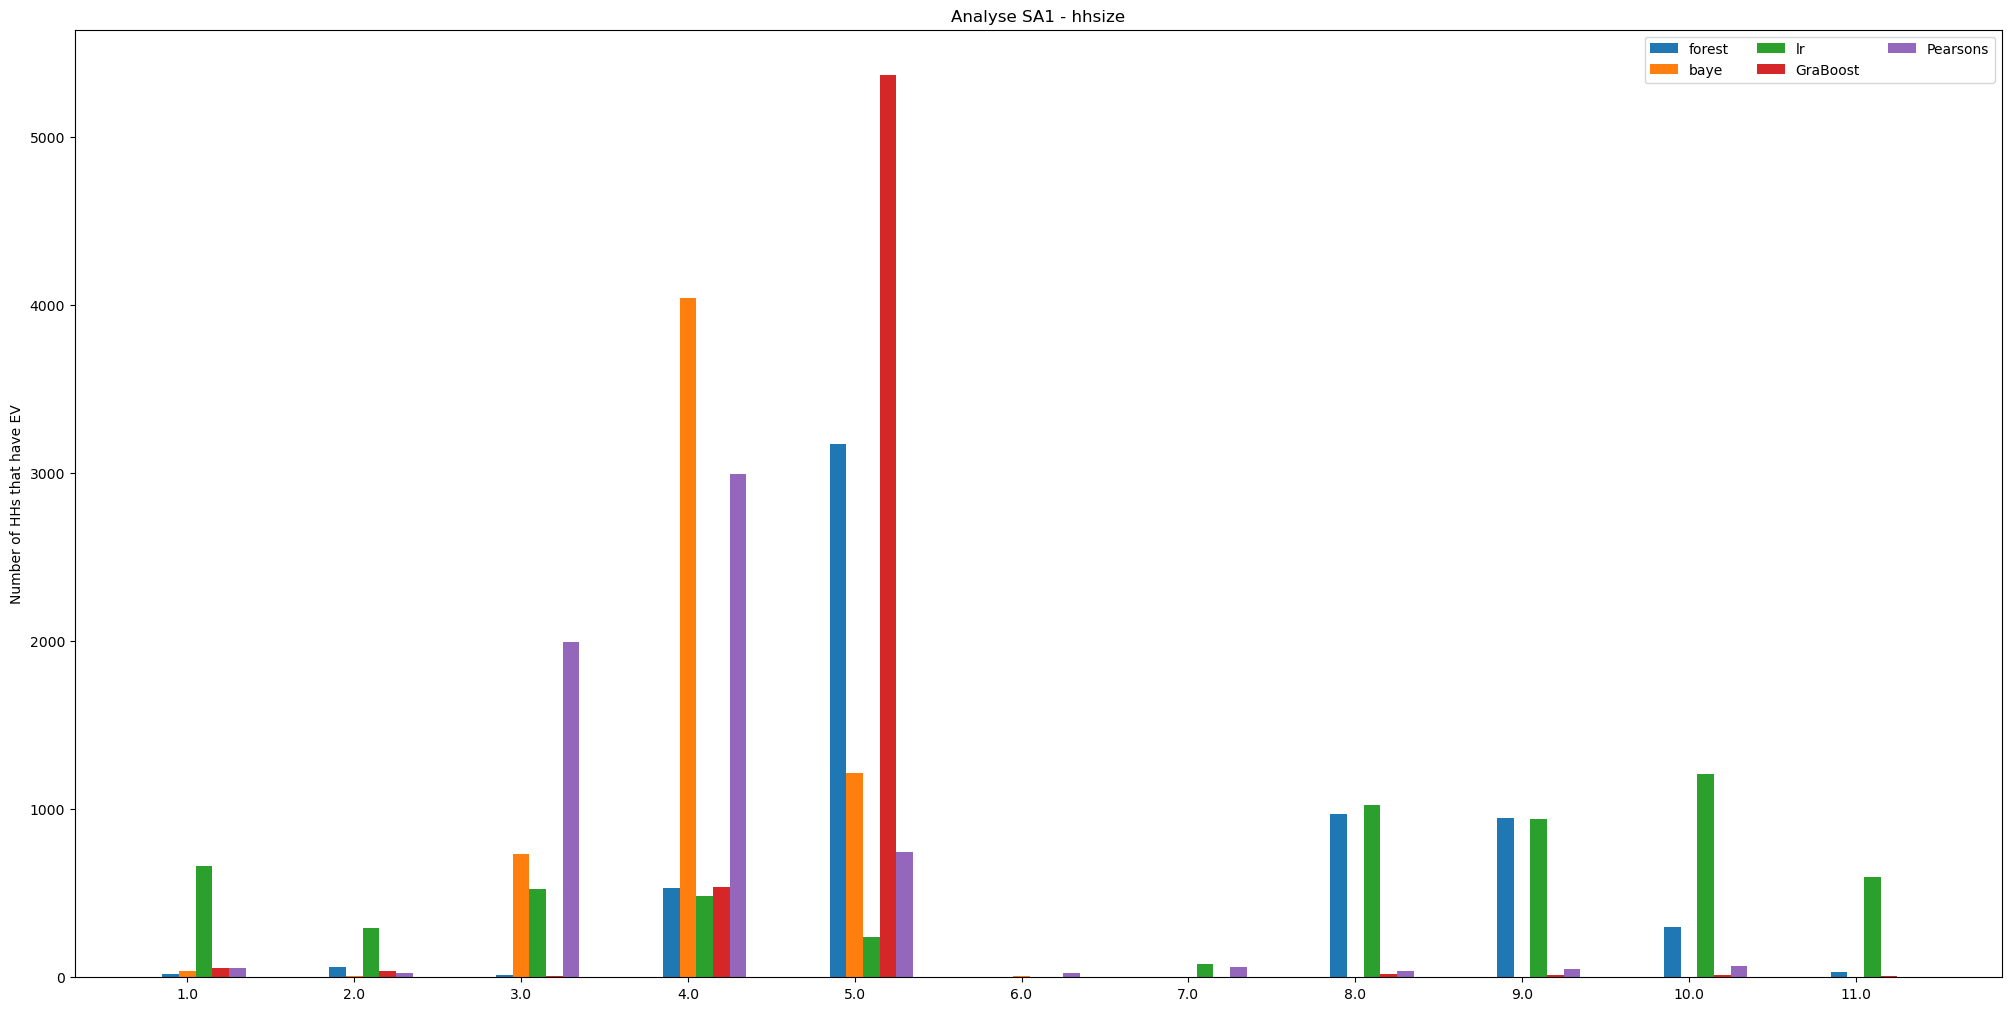

PLOTTING dwelltype


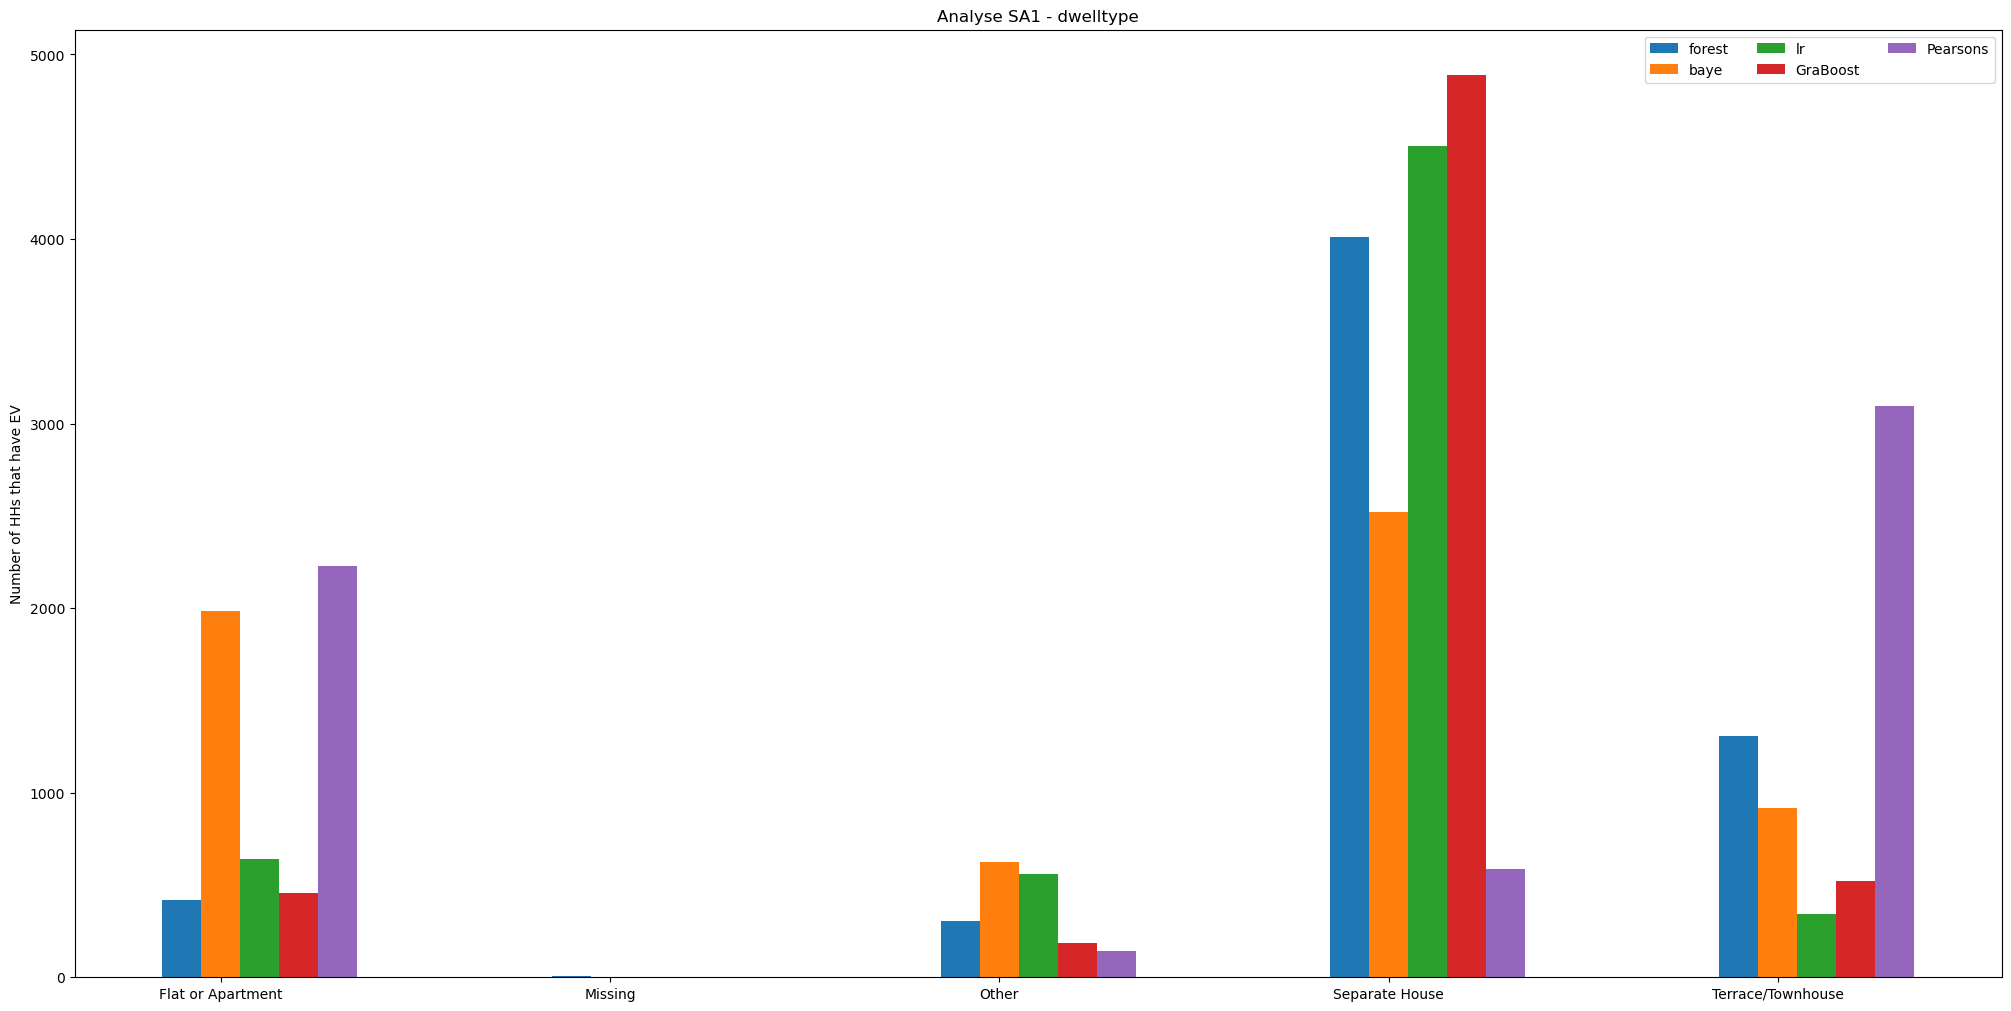

PLOTTING hhinc


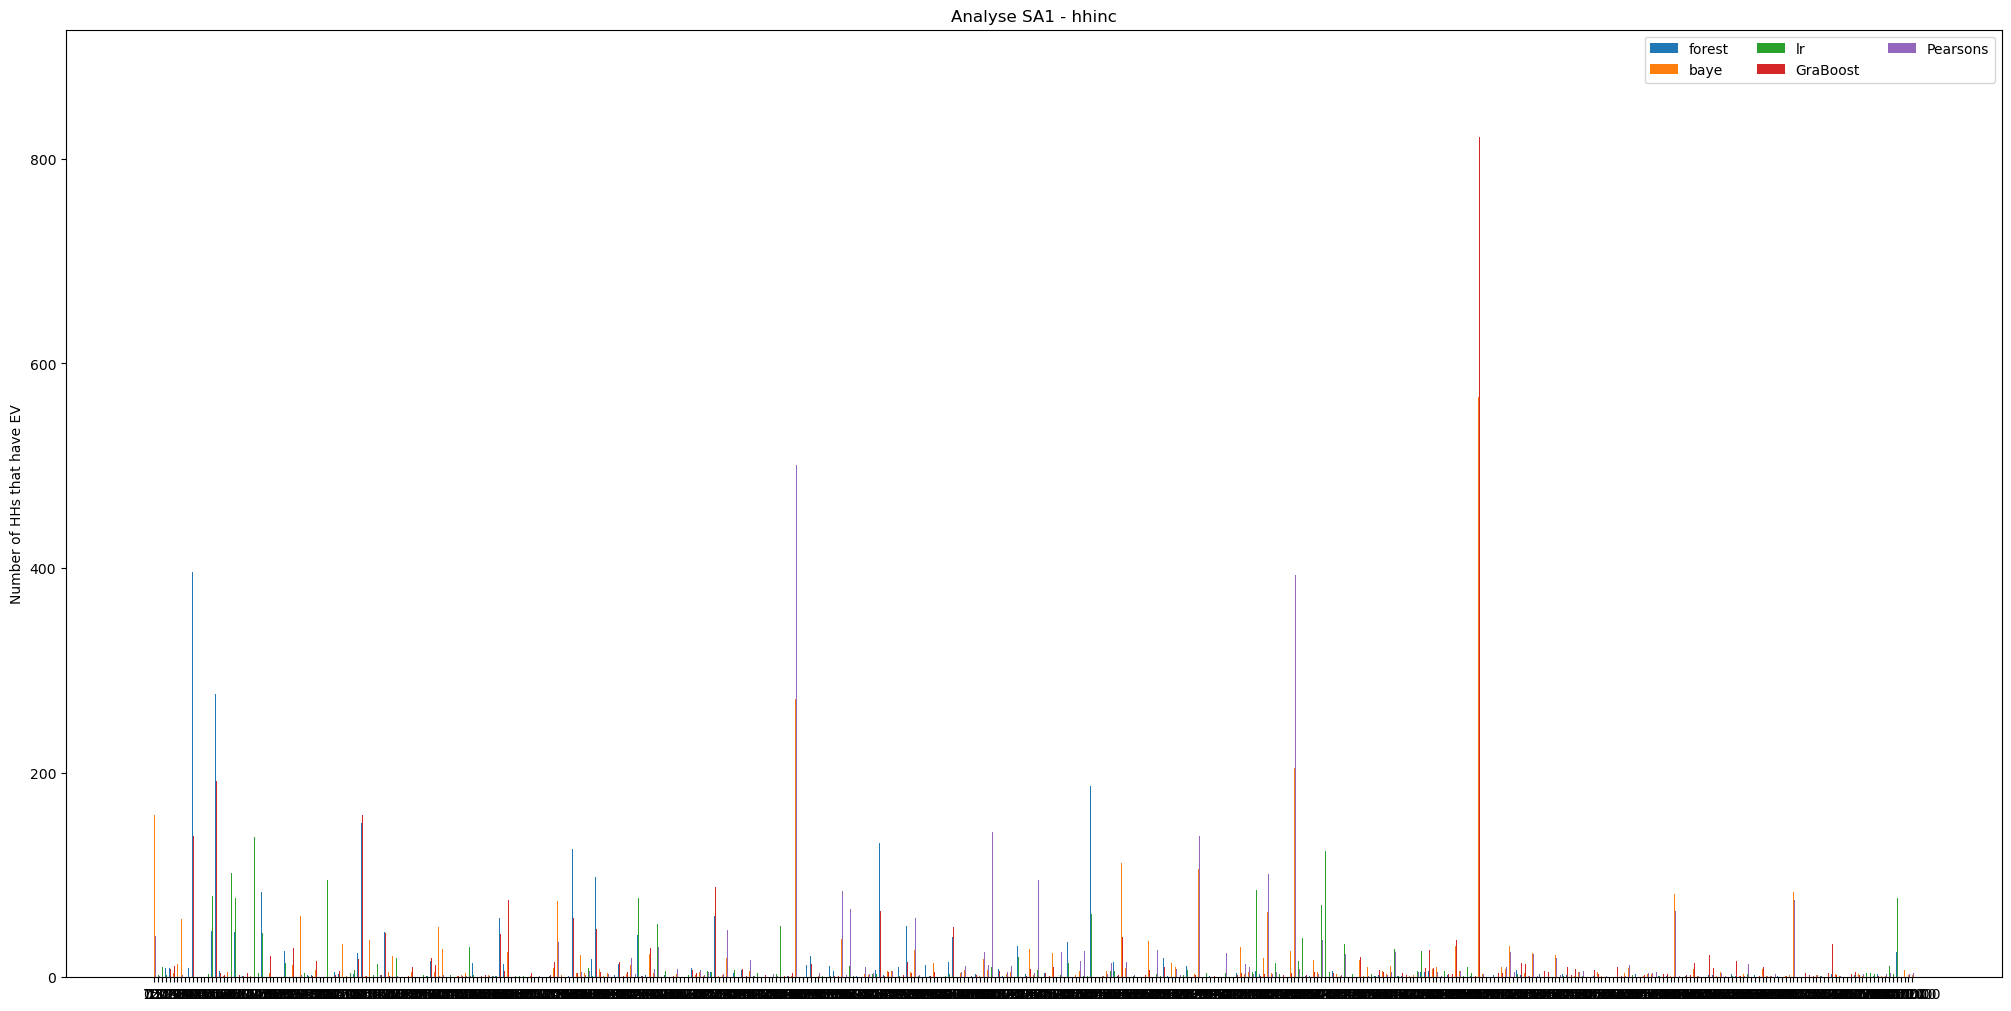

PLOTTING totalvehs


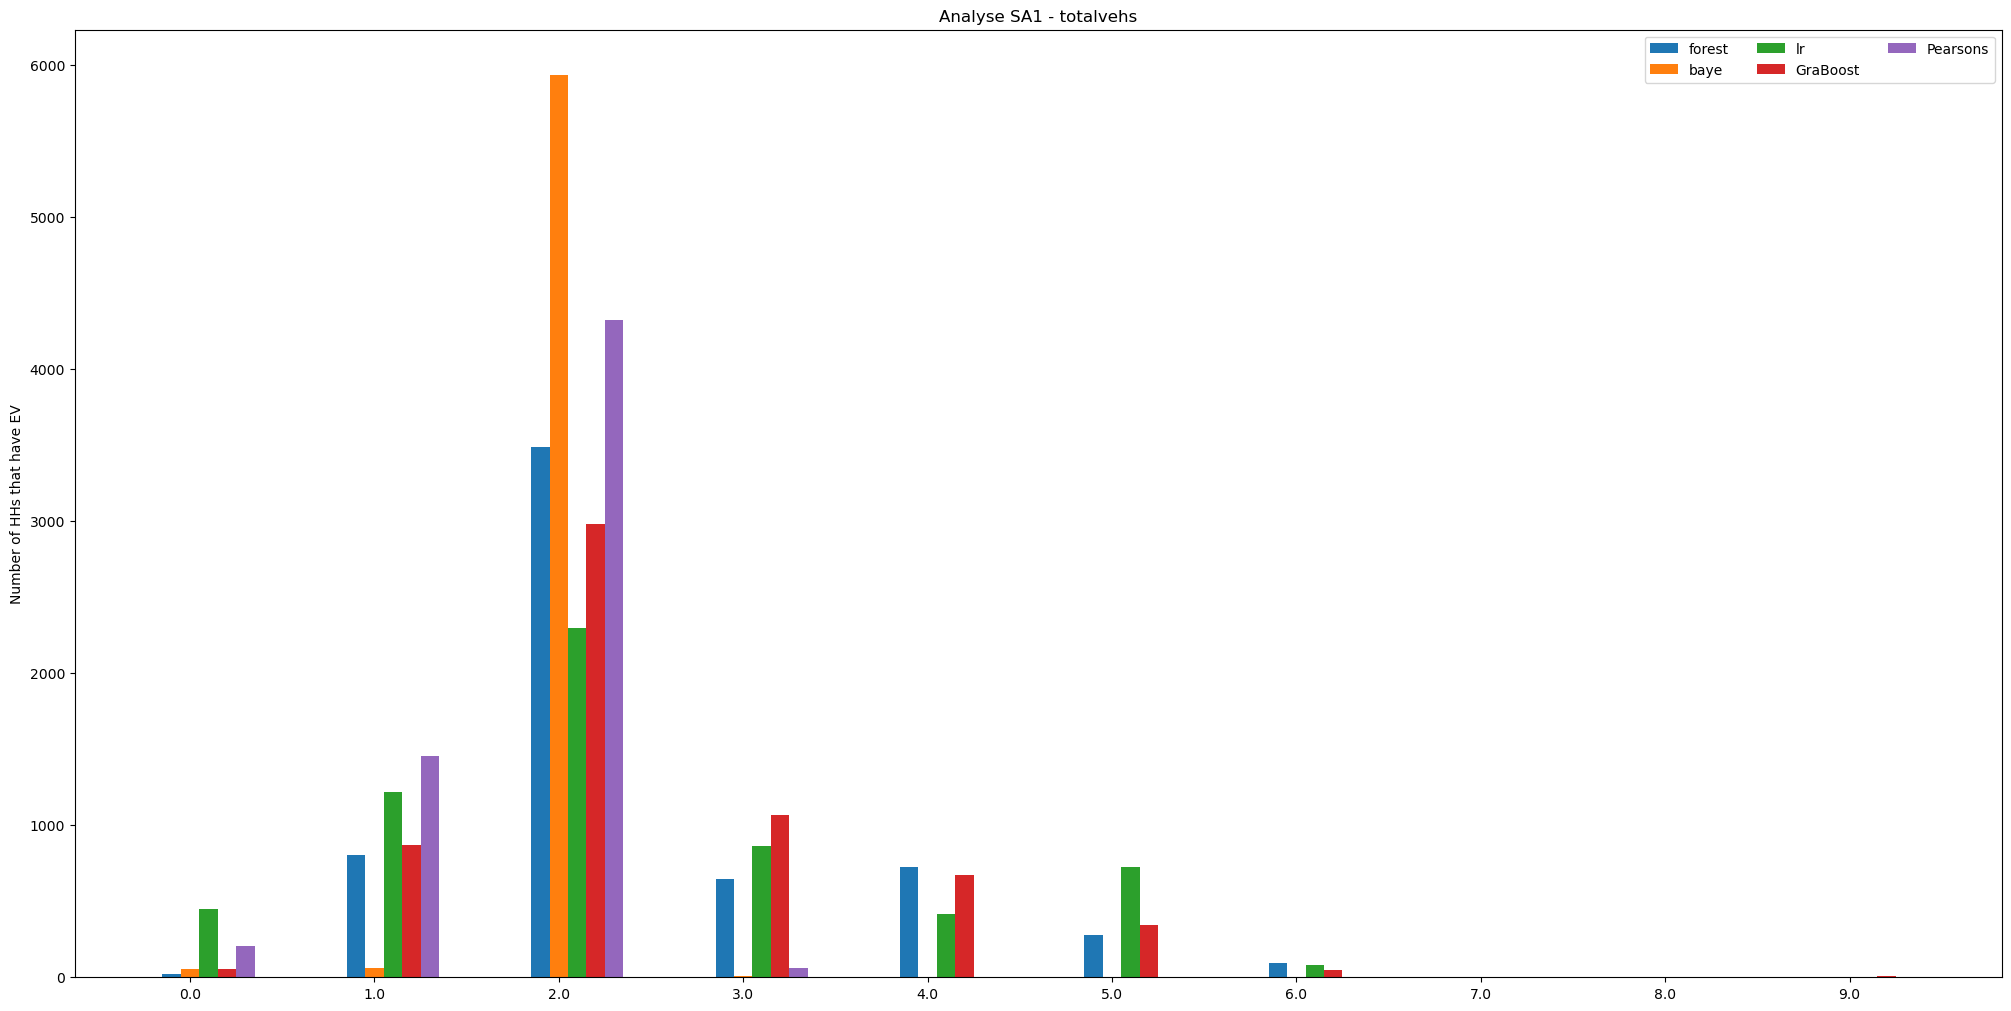

PLOTTING owndwell


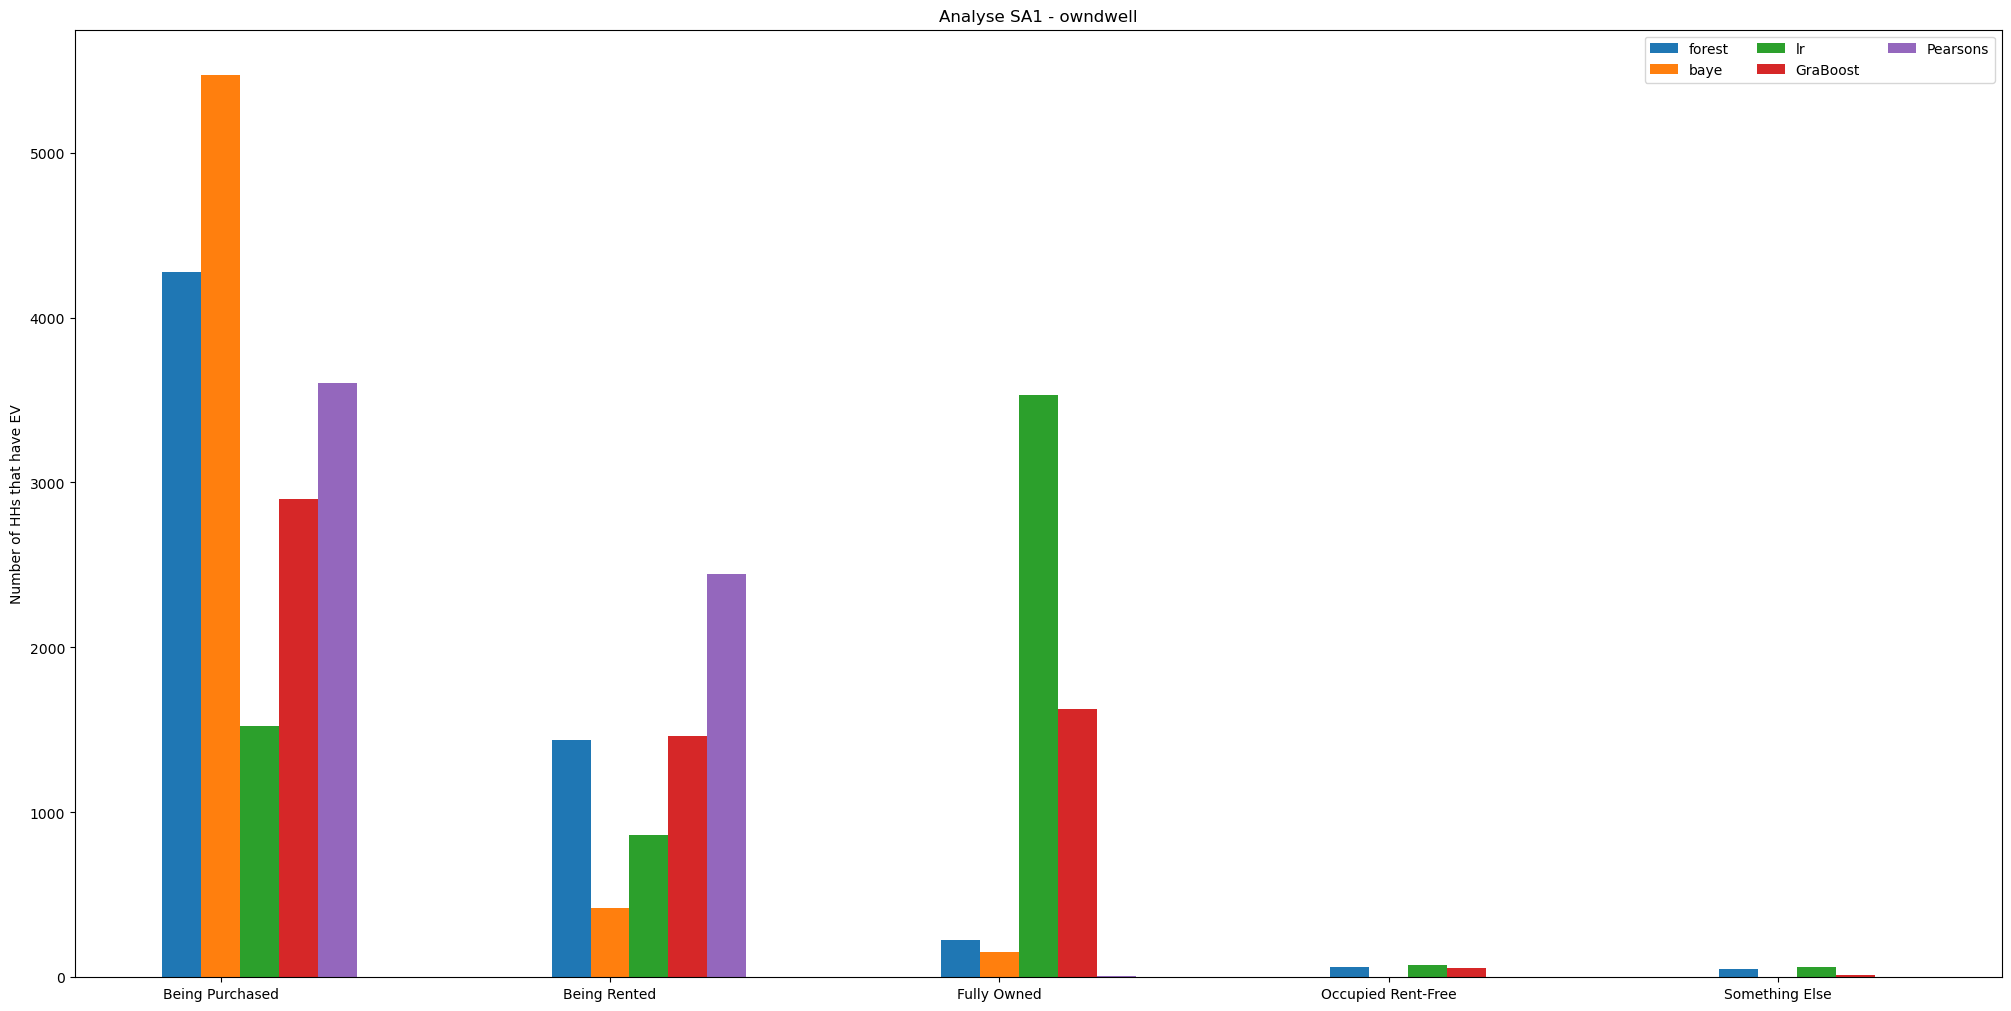

In [103]:
for att in ls_atts_pop:
    to_plot_mul_bars(dict_counts_methods_atts, ls_methods, att)

### Get threshold and see across area

        SA1_CODE21 CHG_FLAG21  CHG_LBL21 SA2_CODE21  \
0      10102100701          0  No change  101021007   
1      10102100702          0  No change  101021007   
2      10102100703          0  No change  101021007   
3      10102100704          0  No change  101021007   
4      10102100705          0  No change  101021007   
...            ...        ...        ...        ...   
61840  90104100407          0  No change  901041004   
61841  90104100408          0  No change  901041004   
61842  99797979993          0  No change  997979799   
61843  99999949999          0  No change  999999499   
61844  ZZZZZZZZZZZ          0  No change  ZZZZZZZZZ   

                                 SA2_NAME21 SA3_CODE21  \
0                                 Braidwood      10102   
1                                 Braidwood      10102   
2                                 Braidwood      10102   
3                                 Braidwood      10102   
4                                 Braidwood      

{'20302104732': {'EV_pred_forest': 0.0019035711595286,
  'EV_pred_baye': -0.0064830515218224,
  'EV_pred_lr': -0.0377013754334362,
  'EV_pred_GraBoost': 0.0014407150466994,
  'EV_pred_Pearsons': -0.2397490594393297},
 '20801116801': {'EV_pred_forest': 0.0021910804463464,
  'EV_pred_baye': 0.0009429619451035,
  'EV_pred_lr': -0.0317641005374967,
  'EV_pred_GraBoost': 0.0014407150466994,
  'EV_pred_Pearsons': -0.0619608078166317},
 '20904143211': {'EV_pred_forest': 0.0016921913003242,
  'EV_pred_baye': -0.0073133085057377,
  'EV_pred_lr': -0.026647259239742,
  'EV_pred_GraBoost': 0.0014407150466994,
  'EV_pred_Pearsons': -0.3044327646755289},
 '21001122825': {'EV_pred_forest': 0.003547522162362,
  'EV_pred_baye': -0.0008830082118278,
  'EV_pred_lr': 0.0090062358159517,
  'EV_pred_GraBoost': 0.0014407150466994,
  'EV_pred_Pearsons': -0.064923618993141},
 '21002123226': {'EV_pred_forest': 0.0022185328628466,
  'EV_pred_baye': -0.0005309105957807,
  'EV_pred_lr': -0.0126047988166566,
  'EV_

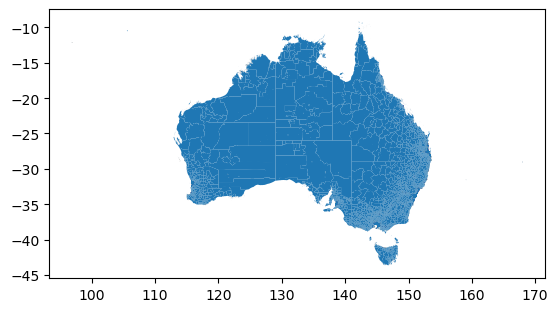

In [108]:
gdf_poa = gpd.read_file("data/SA1_2021_AUST_SHP_GDA2020.zip")
print(gdf_poa)
gdf_poa.plot()
dict_thres

In [ ]:
data_df_build = {
    "SA1_CODE21": []
}

for zone in dict_thres:
    data_df_build["SA1_CODE21"].append(zone)
    for method in dict_thres[zone]:
        me_n = method.split("_")[-1]
        if me_n not in data_df_build:
            data_df_build[me_n] = [dict_thres[zone][method]]
        else:
            data_df_build[me_n].append(dict_thres[zone][method])

df_thres_diff = pd.DataFrame(data_df_build)
df_thres_diff
vic_gpd = gdf_poa.merge(df_thres_diff, on="POA_NAME21")
vic_gpd.plot()

In [ ]:
vic_gpd.plot(column="forest", legend=True, legend_kwds={"label": "Random forest EV thres"})
vic_gpd.plot(column="baye", legend=True, legend_kwds={"label": "Bayesian EV thres"})
vic_gpd.plot(column="lr", legend=True, legend_kwds={"label": "Linear Regression EV thres"})
vic_gpd.plot(column="Pearsons", legend=True, legend_kwds={"label": "Pearons EV thres"})
vic_gpd.plot(column="GraBoost", legend=True, legend_kwds={"label": "Gradient Boosting EV thres"})